# 2 Option pricing using different techniques
### Compare the performance of option pricing with Monte Carlo simulation of a geometric Brownian motion and with a binary tree. To get a realistic input value for the volatility, estimate it from (a) historical stock data or (b) from option prices. Take data for some stock from yahoo or any other source. Indicate clearly in the documentation which date and which underlying you use. Include the code and the data for the estimation of the implied volatility in your project.

### Price a plain vanilla European option, produce the Greeks and least two of the following options: Corridor, knock-in, knock-out, American, Asian, digital option, Bermuda, Quanto. Try to price an American digital option. Discuss the results.
Note: not all options can be priced equally well with a Monte Carlo and a binary tree. Briefly discuss why in your report.


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import math
from itertools import permutations
from itertools import product
import datetime
import pandas_datareader as pdr
import yfinance as yf
%matplotlib inline

#### Classic libraries of Python, itertools useful for binarytrees paths (permutations)
#### Matplotlip inline ----> why ?
#### yfinance for data

In [2]:
start_date=datetime.datetime(2017,11,28)
end_date=datetime.datetime(2023,11,28)
tickers = 'TSLA'
prices = yf.download(tickers, start=start_date, end=end_date)
historical = prices['Adj Close'].dropna(how='all')
ret = historical.pct_change()[1:]
len(ret)

[*********************100%%**********************]  1 of 1 completed


1508

#### Choose any Ticker available on Yahoo! to price options for any security, our sample is composed of 1508 observations (daily returns).

In [3]:
historical = prices['Adj Close'].dropna(how='all')
ret = historical.pct_change()[1:]
days = len(ret)
sample_mean_tsla = np.mean(ret)
sample_std_tsla = np.std(ret, ddof=1) #We use one DoF as we estimate the sample mean (Matteo add something maybe)
lastPrice= S0 = historical.iloc[-1] #Last price very important in any stochastic process (starting point) 
sample_mean_tsla,sample_std_tsla, lastPrice

(0.0024043663221886644, 0.040156388904390154, 236.0800018310547)

#### We now have deriveda realistic input value for the volatility, we have done so by estimating the sample variance of a) historical stock data

## plain vanilla European Option

### Monte Carlo Simulation of a geometric Brownian motion

In [4]:
def monte_carlo_option_price(S, K, r, T, vol, num_simulations,opttype='call'):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price_path = np.zeros(num_days )
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t

        simulated_prices[i, :] = price_path

    if opttype.lower() == 'call':
        
        option_payoffs = np.maximum(simulated_prices[:, -1] - K, 0)  # Payoff for call option at expiration
    elif opptype.lower() == 'put':
    
        option_payoffs = np.maximum(K - simulated_prices[:, -1], 0)  # Payoff for put option at expiration
    else:
        raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")
    option_price = np.exp(-r * T) * np.mean(option_payoffs)

    return option_price, simulated_prices

In [5]:
# Option parameters
S = S0  # Current stock price
K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility
num_simulations = 1000 # Number of Monte Carlo simulations, Higher number = Higher Precision = Higher Processing Power Needed

#### Modify the parameter to fit the macroeconomic context and to tailor your option

In [6]:
option_price, price_paths = monte_carlo_option_price(S, K, r, T, vol, num_simulations,'call') 
print("Price:", option_price, "$") #Here you choose between call and put

Price: 0.6031614960552577 $


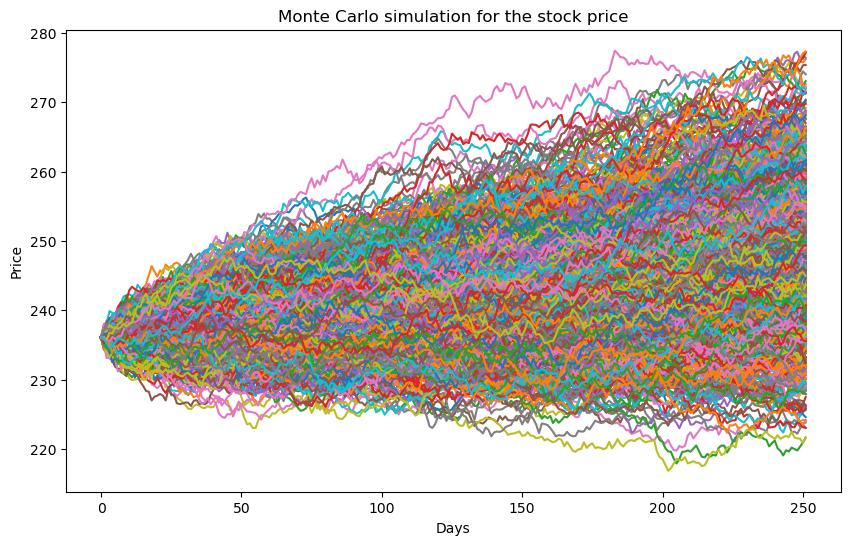

In [7]:
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(price_paths[i, :], label=f'Simulazione {i + 1}')

plt.title('Monte Carlo simulation for the stock price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

#### Greeks for this option

In [8]:
opttype = 'call'
def calculate_european_greeks(S, K, r, T, vol, num_simulations, opttype):
    # Define the small changes for each Greek calculation
    
    delta_S = 0.01 * S
    delta_vol = 0.01 * vol
    delta_T = 1 / 252
    delta_r = 0.01

    # Calculate the base option price
    base_price, _ = monte_carlo_option_price(S, K, r, T, vol, num_simulations, opttype)

    # Delta
    if greek == 'delta':
        price_up, _ = monte_carlo_option_price(S + delta_S, K, r, T, vol, num_simulations, opttype)
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up, _ = monte_carlo_option_price(S, K, r, T, vol + delta_vol, num_simulations, opttype)
        greek_value = (price_vol_up - base_price) / delta_vol

    # Theta
    elif greek == 'theta':
        price_later, _ = monte_carlo_option_price(S, K, r, T + delta_T, vol, num_simulations, opttype)
        greek_value = (base_price - price_later) / delta_T  

    # Gamma
    elif greek == 'gamma':
        price_up, _ = monte_carlo_option_price(S + delta_S, K, r, T, vol, num_simulations, opttype)
        price_down, _ = monte_carlo_option_price(S - delta_S, K, r, T, vol, num_simulations, opttype)
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

    # Rho
    elif greek == 'rho':
        price_r_up, _ = monte_carlo_option_price(S, K, r + delta_r, T, vol, num_simulations, opttype)
        greek_value = (price_r_up - base_price) / delta_r

    return greek_value

# Calculate and print all the Greeks
greeks_to_calculate = ['delta', 'vega', 'theta', 'gamma', 'rho']
for greek in greeks_to_calculate:
    greek_value = calculate_european_greeks(S, K, r, T, vol, num_simulations, opttype)
    print(f"{greek.capitalize()} of the European option: {greek_value}")

Delta of the European option: 0.09843875662722014
Vega of the European option: 273.8076570475847
Theta of the European option: -0.37870950906737644
Gamma of the European option: 0.014252443781665711
Rho of the European option: 39.28660299856688


#### Comment on the Greeks ... 

### Binary Tree 

In [9]:
N = 36# Number of Steps ....
T = 1 # Still in Years
S = S0 = lastPrice
dt = T/N
K = 260 # Stike Price
r = 0.05045

In [10]:
u = np.exp(sample_std_tsla * np.sqrt(dt)) #Cox, Ross and Rubinstein (CRR) #Parameters of the BT
d = 1/u

In [11]:
def binomial_tree_european(K,T,S0,r,N,vol,opttype='call'):
    #precompute constants
    dt = T/N
    u = np.exp(vol * np.sqrt(dt)) #Cox, Ross and Rubinstein (CRR)
    d = 1/u
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N #you are taking the worst scenario 
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d  # you're doing like a zig zag at time T to obtain all the prices

    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype.lower() == 'put':
            C[j] = max(0, K - S[j])
        elif opttype.lower()=='call':
            C[j] = max(0, S[j] - K)
        else:
            raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

       
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )

    return C[0]

print("Price:",binomial_tree_european(K,T,S,r,N,vol,opttype='call'),"$") # Choose call or put here

Price: 0.5318703931520848 $


In [12]:
opttype = 'call' # Choose call or put here

def calculate_european_bingreeks(K,T,S,r,N,vol,opttype):
    # Define the small changes for each Greek calculation
    delta_S = 0.01 * S
    delta_T = 1 / 252
    delta_r = 0.01
    delta_vol = 0.01 * vol
    
    # Calculate the base option price
    base_price = binomial_tree_european(K,T,S,r,N,vol,opttype)

    # Delta
    if greek == 'delta':
        price_up = binomial_tree_european(K,T,S + delta_S,r,N,vol,opttype)
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up = binomial_tree_european(K,T,S,r,N,vol + delta_vol,opttype)
        greek_value = (price_vol_up - base_price) / delta_vol

    # Theta
    elif greek == 'theta':
        price_later = binomial_tree_european(K,T + delta_T,S,r,N,vol,opttype)
        greek_value = (base_price - price_later) / delta_T  # Note that theta is often negative

    # Gamma
    elif greek == 'gamma':
        price_up = binomial_tree_european(K,T,S + delta_S,r,N,vol,opttype)
        price_down = binomial_tree_european(K,T,S - delta_S,r,N,vol,opttype)
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

    # Rho
    elif greek == 'rho':
        price_r_up = binomial_tree_european(K,T,S,r + delta_r,N,vol,opttype)
        greek_value = (price_r_up - base_price) / delta_r

    return greek_value

# Example usage
S0 = lastPrice  # Current stock price
K = 260  # Strike price
r = 0.05  # Risk-free interest rate
T = 1  # Time to expiration in years
vol = sample_std_tsla  # Volatility
num_simulations = 100


# Calculate and print all the Greeks
greeks_to_calculate = ['delta', 'vega', 'theta', 'gamma', 'rho']
for greek in greeks_to_calculate:
    greek_value = calculate_european_bingreeks(K,T,S,r,N,vol,opttype)
    print(f"{greek.capitalize()} of the European option: {greek_value}")

Delta of the European option: 0.1568201017767338
Vega of the European option: 36.21532943450385
Theta of the European option: -2.0525214969821395
Gamma of the European option: 0.011736458679744592
Rho of the European option: 32.020441894417274


#### Small different in price between the 2 methods (we need to quantify it)
#### Also difference in the greeks

### American

In [13]:
#Price is lower here because you have more 0, more days with no payoff, so the average is affected. 
#If you are a smart trader, you will have a strategy to exit at a good time
#We assume that the trader will not exercice the option when the value is 0, but only when he has a payoff

def monte_carlo_american_option_price(S, K, r, T, vol, num_simulations, option_type='call'):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration
    discount_factors = np.exp(-r * np.arange(num_days) * dt)  # Discount factors for each day

    simulated_prices = np.zeros((num_simulations, num_days))
    option_values = np.zeros((num_simulations, num_days))  # Store option values at each step

    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_path[day] = price_path[day - 1] * np.exp(drift + diffusion)
            
        simulated_prices[i, :] = price_path  # Store the simulated price path

        # Calculate option intrinsic values at each step (consider all steps for American option)
        if option_type.lower() == 'call':
            option_values[i, :] = np.maximum(price_path - K, 0)  # Call option payoff for each day
        elif option_type.lower() == 'put':
            option_values[i, :] = np.maximum(K - price_path, 0)  # Put option payoff for each day

    # Discount the option values to present value
    discounted_option_values = option_values * discount_factors

    # Filter out non-positive payoffs and flatten the array
    positive_discounted_payoffs = discounted_option_values[discounted_option_values > 0]

    # Calculate the average of the positive payoffs
    
    option_price = np.mean(positive_discounted_payoffs)

    return option_price, simulated_prices


#----------

K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility
num_simulations = 1000 # Number of Monte Carlo simulations

#----------

# Call the function with 'call' as a string
option_price, price_paths = monte_carlo_american_option_price(S0, K, r, T, vol, num_simulations, 'call')
print("Price:", option_price, "$")

Price: 3.8182913050620337 $


In [14]:
option_type = 'call'
def calculate_american_greeks(S, K, r, T, vol, num_simulations, option_type):
    # Define the small changes for each Greek calculation
    delta_S = 0.01 * S
    delta_vol = 0.01 * vol
    delta_T = 1 / 252
    delta_r = 0.01

    # Calculate the base option price
    base_price, _ = monte_carlo_american_option_price(S, K, r, T, vol, num_simulations, option_type)

    # Delta
    if greek == 'delta':
        price_up, _ = monte_carlo_american_option_price(S + delta_S, K, r, T, vol, num_simulations, option_type)
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up, _ = monte_carlo_american_option_price(S, K, r, T, vol + delta_vol, num_simulations, option_type)
        greek_value = (price_vol_up - base_price) / delta_vol

    # Theta
    elif greek == 'theta':
        price_later, _ = monte_carlo_american_option_price(S, K, r, T + delta_T, vol, num_simulations, option_type)
        greek_value = (base_price - price_later) / delta_T  # Note that theta is often negative

    # Gamma
    elif greek == 'gamma':
        price_up, _ = monte_carlo_american_option_price(S + delta_S, K, r, T, vol, num_simulations, option_type)
        price_down, _ = monte_carlo_american_option_price(S - delta_S, K, r, T, vol, num_simulations, option_type)
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

    # Rho
    elif greek == 'rho':
        price_r_up, _ = monte_carlo_american_option_price(S, K, r + delta_r, T, vol, num_simulations, option_type)
        greek_value = (price_r_up - base_price) / delta_r

    return greek_value


# Calculate and print all the Greeks
greeks_to_calculate = ['delta', 'vega', 'theta', 'gamma', 'rho']
for greek in greeks_to_calculate:
    greek_value = calculate_american_greeks(S, K, r, T, vol, num_simulations, option_type)
    print(f"{greek.capitalize()} of the American option: {greek_value}")

Delta of the American option: 0.09069027023785728
Vega of the American option: -638.7279097677895
Theta of the American option: -132.7793556612545
Gamma of the American option: 0.03753251457584979
Rho of the American option: -33.005619040163126


In [18]:
def american_tree(K,T,S0,r,N,vol,opttype='call'):
    #precompute values
    dt = T/N
    u = np.exp(vol * np.sqrt(dt)) #Cox, Ross and Rubinstein (CRR)
    d = 1/u
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)

    # initialise stock prices at maturity
    S = np.zeros(N+1)
    for j in range(0, N+1):
        S[j] = S0 * u**j * d**(N-j)

    # option payoff
    C = np.zeros(N+1)
    for j in range(0, N+1):
        if opttype.lower() == 'put':
            C[j] = max(0, K - S[j])
        elif opttype.lower()=='call':
            C[j] = max(0, S[j] - K)
        else:
            raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")


    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            S = S0 * u**j * d**(i-j)
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
            if opttype.lower() == 'put':
                C[j] = max(C[j], K - S)
            else:
                C[j] = max(C[j], S - K)

    return C[0]

american_tree(K,T,S0,r,252,vol,opttype='call')  

0.5940902494287987

In [22]:
opttype = 'call'
N=252
def calculate_american_bingreeks(K,T,S0,r,N,vol,opttype):
    # Define the small changes for each Greek calculation
    delta_S = 0.01 * S
    delta_T = 1 / 252
    delta_r = 0.01
    delta_vol = 0.01 * vol
    
    # Calculate the base option price
    base_price = american_tree(K,T,S0,r,N,vol,opttype) 

    # Delta
    if greek == 'delta':
        price_up = american_tree(K,T,S0 + delta_S,r,N,vol,opttype) 
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up = american_tree(K,T,S0,r,N,vol + delta_vol,opttype) 
        greek_value = (price_vol_up - base_price) / delta_vol

    # Theta
    elif greek == 'theta':
        price_later =  american_tree(K,T + delta_T,S0,r,N,vol,opttype) 
        greek_value = (base_price - price_later) / delta_T  # Note that theta is often negative

    # Gamma
    elif greek == 'gamma':
        price_up = american_tree(K,T,S0 + delta_S,r,N,vol,opttype) 
        price_down = american_tree(K,T,S0 - delta_S,r,N,vol,opttype) 
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

    # Rho
    elif greek == 'rho':
        price_r_up = american_tree(K,T,S0,r + delta_r,N,vol,opttype) 
        greek_value = (price_r_up - base_price) / delta_r

    return greek_value

# Example usage
S0 = lastPrice  # Current stock price
K = 260  # Strike price
r = 0.05  # Risk-free interest rate
T = 1  # Time to expiration in years
vol = sample_std_tsla  # Volatility
num_simulations = 100


# Calculate and print all the Greeks
greeks_to_calculate = ['delta', 'vega', 'theta', 'gamma', 'rho']
for greek in greeks_to_calculate:
    greek_value = calculate_american_bingreeks(K,T,S0,r,N,vol,opttype)
    print(f"{greek.capitalize()} of the american option: {greek_value}")

Delta of the american option: 0.15527819330049883
Vega of the american option: 50.922121959047494
Theta of the american option: -2.318491466410486
Gamma of the american option: 0.011088447478463524
Rho of the american option: 35.45769831388904


### digital option

In [24]:
def monte_carlo_digital_option_price(S, K, r, T, vol, win, num_simulations):
    dt = 1 / 252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t

        # Check the condition for payment and set the simulated prices accordingly
        if (S <= K and np.max(price_path) >= K) or (S > K and np.min(price_path) < K):
            simulated_prices[i] = win
        else:
            simulated_prices[i] = 0

    option_price = np.exp(-r * T) * np.mean(simulated_prices)
    return option_price

In [25]:
# Option parameters
S = S0  # Current stock price
K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 1  # Time to expiration (in years)
win=1
vol = sample_std_tsla  # Volatility
num_simulations = 10000 # Number of Monte Carlo simulations

In [26]:
print("Price:", monte_carlo_digital_option_price(S, K, r, T, vol,win, num_simulations), "$")

Price: 0.15697732229369746 $


In [ ]:
def american_digital_tree(S, barrier, r, vol, T=1,win=1, N=10):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    paths = [''.join(seq) for seq in product('ud', repeat=N)]  #chatgpt

    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))

    for i, path in enumerate(paths):
        prices = [S]
        probability = 1

        for num in path:
            if num == 'u':  # u
                prices.append(prices[-1] * u)
                probability *= p
            else:  # d
                prices.append(prices[-1] * d)
                probability *= (1 - p)
        if S < barrier:
            # Opzione digitale americana: paga 1 se il massimo dei prezzi supera la barriera, altrimenti paga 0
            payoff = win if max(prices) >= barrier else 0
        else:
            payoff = win if min(prices) <= barrier else 0

        payoffs[i] = payoff
        probabilities[i] = probability

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price

print("Prezzo dell'opzione:",american_digital_tree(S, K, r, vol,T, 1,20))

### knock-out

In [ ]:
def monte_carlo_knockout(S, K, B, r, T, vol, num_simulations, option_type="call"):
    # Precompute constants
    dt = T / 252
    nudt = (r - 0.5 * vol ** 2) * dt
    volsdt = vol * np.sqrt(dt)
    num_days = int(T * 252)  
    sum_CT = 0
    
    for i in range(num_simulations):
        # Barrier Crossed Flag
        BARRIER = False
        St = S

        for j in range(num_days):
            epsilon = np.random.normal()
            St = St * np.exp(nudt + volsdt * epsilon)

            # Check if barrier is crossed
            if (S <= B and St >= B) or (S > B and St <= B):
                BARRIER = True
                break

        if BARRIER:
            CT = 0
        else:
            if option_type == "call":
                CT = max(0, St - K)
            elif option_type == "put":
                CT = max(0, K - St)
            else:
                raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

        sum_CT += CT

    option_price = np.exp(-r * T) * sum_CT / num_simulations
    return option_price

In [ ]:
print("Price:", monte_carlo_knockout(230,220,240,r,T,vol,M,"put"),"$")

In [ ]:
def knock_out_tree(S, K, barrier, r, vol, T=1, N=10, opttype='call'):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    paths = [''.join(seq) for seq in product('ud', repeat=N)]  #chatgpt

    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))

    for i, path in enumerate(paths):
        prices = [S]
        probability = 1

        for num in path:
            if num == 'u':  # u
                prices.append(prices[-1] * u)
                probability *= p
            else:  # d
                prices.append(prices[-1] * d)
                probability *= (1 - p)

        if S < barrier:
            # Opzione knock-out: paga 0 se il massimo dei prezzi supera la barriera, altrimenti calcola il payoff normale
            payoff = 0 if max(prices) > barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])
        else:
            # Opzione knock-out: paga 0 se il minimo dei prezzi supera la barriera, altrimenti calcola il payoff normale
            payoff = 0 if min(prices) < barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])

        payoffs[i] = payoff
        probabilities[i] = probability

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price

print(knock_out_tree(230,220,240,r,vol,T,10,'put'))

### knock-in

In [ ]:
def monte_carlo_knockin(S, K, B, r, T, vol, num_simulations, option_type="call"):
    dt = T / 252
    nudt = (r - 0.5 * vol ** 2) * dt
    volsdt = vol * np.sqrt(dt)
    num_days = int(T * 252)
    sum_CT = 0

    for i in range(num_simulations):
        # Knock-in Flag
        KNOCKIN = False
        St = S

        for j in range(num_days):
            epsilon = np.random.normal()
            St = St * np.exp(nudt + volsdt * epsilon)

            # Check if knock-in condition is met
            if (S <= B and St >= B) or (S > B and St <= B):
                KNOCKIN = True
                break

        if KNOCKIN:
            if option_type == "call":
                CT = max(0, St - K)
            elif option_type == "put":
                CT = max(0, K - St)
            else:
                raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

            sum_CT += CT

    option_price = np.exp(-r * T) * sum_CT / num_simulations
    return option_price

In [ ]:
print(monte_carlo_knockin(230,250,240,r,T,vol,M,"put"))

In [ ]:
def knock_in_tree(S, K, barrier, r, vol, T, N=10, opttype='call'):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    paths = [''.join(seq) for seq in product('ud', repeat=N)]  #chatgpt

    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))

    for i, path in enumerate(paths):
        prices = [S]
        probability = 1

        for num in path:
            if num == 'u':  
                prices.append(prices[-1] * u)
                probability *= p
            else:  # d
                prices.append(prices[-1] * d)
                probability *= (1 - p)

        if S < barrier:# so the price have to surpass the barrier
            payoff = 0 if max(prices) < barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])
        else:
            payoff = 0 if min(prices) > barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])

        payoffs[i] = payoff
        probabilities[i] = probability

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price


In [ ]:
print(knock_in_tree(230,250,240,r,vol,T,18,'put'))

### Asian Option

In [ ]:
def monte_carlo_asian_option_price(S, K, r, T, vol, num_simulations, option_type='call', 
                                   average_type='arithmetic', 
                                   payoff_type='average', avg_start=10, avg_end=100):
    
    dt = 1/252  # Time step, assuming 252 trading days in a year
    num_days = int(T * 252)  # Total number of days in the period of interest
    discount_factor = np.exp(-r * T)  # Discount factor for the option's lifetime

    simulated_prices = np.zeros((num_simulations, num_days))
    payoffs = np.zeros(num_simulations)

    # Generate simulated price paths
    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S
        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_path[day] = price_path[day - 1] * np.exp(drift + diffusion)
        simulated_prices[i, :] = price_path  # Store the simulated price path

        # Select the observation dates for the average
        observation_dates = np.arange(avg_start, avg_end)

        # Calculate the average price over the selected period
        observed_prices = price_path[observation_dates]
        if average_type == 'arithmetic':
            average_price = np.mean(observed_prices)
        elif average_type == 'geometric':
            average_price = np.exp(np.mean(np.log(observed_prices)))

        # Determine the strike price based on the payoff type
        if payoff_type == 'average':
            strike_price = average_price
        elif payoff_type == 'fixed':
            strike_price = K

        # Calculate the payoff based on the average price and option type
        if option_type.lower() == 'call':
            payoff = max(average_price - strike_price, 0)
        elif option_type.lower() == 'put':
            payoff = max(strike_price - average_price, 0)
        payoffs[i] = payoff

    # Calculate the option price by discounting the average payoff
    option_price = np.mean(payoffs) * discount_factor

    return option_price, simulated_prices

# Define your parameters (placeholders)
S0 = lastPrice  # Current stock price
K = 260  # Strike price
r = 0.05  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = 0.2  # Volatility, adjust as needed
num_simulations = 1000  # Number of Monte Carlo simulations
num_days = 252
# Define your averaging period start and end days
avg_start_day = 10  # Start of the averaging period, change as needed
avg_end_day = 100 # End of the averaging period, change as needed

# Call the modified function
option_price, simulated_prices = monte_carlo_asian_option_price(
    S0, K, r, T, vol, num_simulations, option_type='call', 
    average_type='arithmetic', 
    payoff_type='fixed', avg_start=0, avg_end=252)

print("Asian Option Price:", option_price)

In [ ]:

def asian_option(S, K, r, vol, T=1, call=True, arithmetic=True, price=True, N=10, start_period=0, end_period=None):
    if end_period is None:
        end_period = int(T * N)
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    paths = [''.join(seq) for seq in product('ud', repeat=N)]  #chatgpt
    
    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))
    averages = np.zeros(len(paths))

    for i, path in enumerate(paths):
        previous_price = S
        probability = 1
        avg_prices = []

        for num in path:
            if num == 'u':  # u
                previous_price *= u
                probability *= p
            else:  # d
                previous_price *= d
                probability *= (1 - p)

            avg_prices.append(previous_price)

        avg_prices = avg_prices[start_period-1:end_period]
        avg_value = np.mean(avg_prices) if arithmetic else np.exp(np.mean(np.log(avg_prices)))

        if price:
            payoff = max(0, avg_value - K) if call else max(0, K - avg_value)
        else:
            payoff = max(0, avg_prices[-1] - avg_value) if call else max(0, avg_value - avg_prices[-1])

        payoffs[i] = payoff
        probabilities[i] = probability
        averages[i] = avg_value

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price


print(asian_option(S, K, r, vol, T, call=True, arithmetic=True, price=True, N=10))
